# Practical 3: Dgital Elevation Models

In this practical, we'll make visualizations and calculate derived quantities of LiDAR DEMs of the Kīlauea volcano on the Big Island of Hawai'i. The DEMs cover the main volcano summit and the Halemau'mau crater from before and after the [2018 lower East Rift zone eruption](https://www.usgs.gov/volcanoes/kilauea/2018-lower-east-rift-zone-eruption-and-summit-collapse).

[![Aerial photo of Halemau'mau crater and part of the Kīlauea caldera taken on July 13, 2018](https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/thumbnails/image/img6670.jpg)](https://www.usgs.gov/media/images/aerial-view-k-lauea-summit-july-13-2018)
*Aerial photo of Halemau'mau crater and part of the Kīlauea caldera taken on July 13, 2018. The buildings housed the USGS Hawaiian Volcano Observatory and Hawai‘i Volcanoes National Park's Jaggar Museum. Source: [USGS](https://www.usgs.gov/media/images/aerial-view-k-lauea-summit-july-13-2018) (public domain).*

## Import the required libraries

We'll start by importing the things we'll need to load the images, do some calculations, and plot them.

In [2]:
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

## Download the DEMs

The DEMs are available as TIFF files (click to download):

* [`kilauea2009.tif`](https://github.com/leouieda/remote-sensing/raw/main/data/kilauea/kilauea2009.tif) (source: [Hawaii Big Island Survey](https://doi.org/10.5069/G9DZ067X))
* [`kilauea2018.tif`](https://github.com/leouieda/remote-sensing/raw/main/data/kilauea/kilauea2018.tif) (source: [Kilauea Volcano, HI July 2018 Acquisition](https://doi.org/10.5069/G9M32SV1))

Both were generated with **2 meter** grid node spacing and covering the same are (they share the Southwester corner coordinates). The value -9999 indicates missing data and need to be converted to Not-a-Number (NaN) values (see [`numpy.nan`](https://numpy.org/doc/stable/reference/constants.html?highlight=nan#numpy.nan)).

**Place both files in the same folder as this notebook.** After that, we can load them with scikit-image.

In [3]:
kilauea2018 = skimage.io.imread("../data/kilauea/kilauea2018.tif")
kilauea2009 = skimage.io.imread("../data/kilauea/kilauea2009.tif")

In [6]:
kilauea2009

array([[-9999.  , -9999.  , -9999.  , ..., -9999.  , -9999.  , -9999.  ],
       [-9999.  , -9999.  , -9999.  , ..., -9999.  , -9999.  , -9999.  ],
       [-9999.  , -9999.  , -9999.  , ..., -9999.  , -9999.  , -9999.  ],
       ...,
       [ 1147.85,  1147.94,  1147.99, ..., -9999.  , -9999.  , -9999.  ],
       [ 1147.87,  1147.88,  1147.99, ..., -9999.  , -9999.  , -9999.  ],
       [-9999.  , -9999.  , -9999.  , ..., -9999.  , -9999.  , -9999.  ]],
      dtype=float32)

In [12]:
def set_nans(dem):
    dem[dem == -9999] = np.nan
    return dem

In [8]:
kilauea2009[kilauea2009 == -9999] = np.nan
kilauea2018[kilauea2018 == -9999] = np.nan

### Your turn

Make pseudo-color maps of both DEMs (including a colorbar). Choose an [appropriate colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for these plots. It helps if you ensure that the maximum and minimum values of the colorbar are the same for both plots. You can do this by setting the `vmin` and `vmax` parameters of `plt.imshow`.

## Profiles

It can be helpful for visualization to extract profiles across features of the DEMs. This reduces the dimensions of the DEMs and allows for easier comparison of different datasets (both DEMs can be visualized in the same plot).

For simplicity, we'll extract East-West profiles across the Halemau'mau crater to visualize the summit collapse. Extracting profiles along arbitrary lines is a bit more complicated and involves interpolation of the data. In Python, it can be done with the [Verde](https://www.fatiando.org/verde/latest/) library.

In [9]:
profile_2018 = kilauea2018[1500, :]

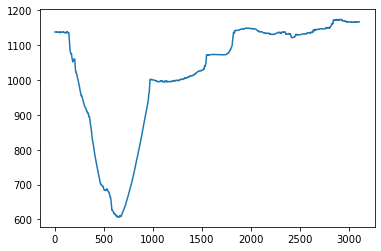

In [10]:
plt.figure()
plt.plot(profile_2018)

### Your turn

Extract the same profile across the 2018 DEM and plot both together in the same figure for comparison.

## Calculating slope

The slope of the DEM gives the surface inclination (relative to the horizontal plane) at each pixel. 

In [23]:
def slope(a):
    dx = np.zeros_like(a)
    dx[:, 1:-1] = (a[:, 2:] - a[:, :-2]) / (4)
    dy = np.zeros_like(a)
    dy[1:-1, :] = (a[2:, :] - a[:-2, :]) / (4)
    return np.degrees(np.arctan(np.hypot(dx, dy)))

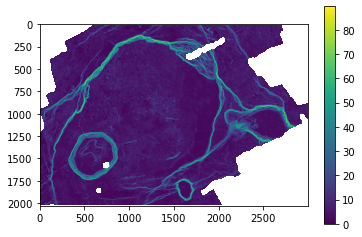

In [27]:
plt.imshow(slope(before))
plt.colorbar()

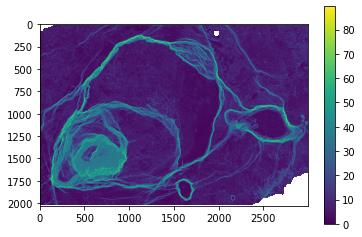

In [28]:
plt.imshow(slope(after))
plt.colorbar()

### Your turn

Create a function that calculates the slope of a given DEM (include a docstring). Apply your function to calculate the slope of the 2018 DEM. Make a pseudo-color plot of the slope to compare with the 2009 slope.

## Hillshading

This is the processes of adding artificial light and shade to a raster dataset (a grid). Matplotlib has capabilities for doing this with the `matplotlib.colors.LightSource` class.

In [8]:
light = LightSource()
after_shade = light.shade(np.nan_to_num(after), plt.cm.gray, vmin=200, vmax=2000)
before_shade = light.shade(np.nan_to_num(before), plt.cm.gray, vmin=200, vmax=2000)

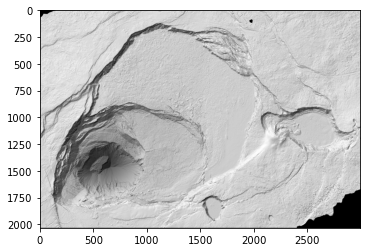

In [9]:
plt.imshow(after_shade)

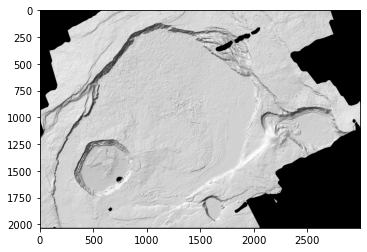

In [10]:
plt.imshow(before_shade)

## Spatial and volumetric analysis

Having co-registered DEMs from before and after the summit collapse allows us to calculate the difference between the two topographic surfaces. 

In [11]:
diff = before - after

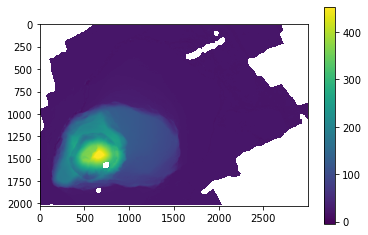

In [17]:
vmin, vmax = np.nanpercentile(diff, (0, 99.9))

plt.imshow(diff, vmin=vmin, vmax=vmax)
plt.colorbar()

### Your turn

Estimate the total volume change in the crater that resulted from the summit collapse. Compare your estimate with the [official USGS numbers](https://volcanoes.usgs.gov/vsc/file_mngr/file-192/PrelimSum_LERZ-Summit_2018.pdf). Consider and discuss the sources of uncertainty in your estimate.

Tip: Adding, subtracting, multiplying, and dividing `np.nan` with any number results in a `np.nan` value. To safely work with data containing NaNs, use the `nan` version of numpy functions, like `np.nanmax`, `np.nanmean`, etc. 

In [21]:
np.nansum(diff) * 2**2

1044317952.0